# Explaining GNN Model Predictions using Captum

Mutagenicity dataset from [TUDatasets](https://chrsmrrs.github.io/datasets/). This dataset consists of 4337 molecule graphs where the task is to predict the molecule mutagenicity.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
import pandas as pd
import random

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Loading the dataset

load the dataset (10% of the data as the test split)

In [12]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

# proxy = 'http://webproxy:8080'

# os.environ['http_proxy'] = proxy
# os.environ['HTTP_PROXY'] = proxy
# os.environ['https_proxy'] = proxy
# os.environ['HTTPS_PROXY'] = proxy

In [13]:
achse_mat = scipy.io.loadmat('/content/drive/MyDrive/Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

sensor_names = ['Mic', 'Acc_PB', 'Acc_BB', 'Acc_PR', 'Ax_F', 'Pres', 'Vel', 'Act_Curr', 'Mot_Curr_1', 'Mot_Curr_2', 'Mot_Curr_3']

/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [14]:
ranges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform label encoding
def label_mapping(x):
    return labels[x - 1]

# Perform label encoding
encoded_target = np.digitize(train_target_reshaped, ranges, right=True)
train_target_reshaped = np.vectorize(label_mapping)(encoded_target)

print((train_target_reshaped).shape)

(4766,)


In [15]:
print(train_target_reshaped.dtype)

int64


In [16]:
train_target_reshaped

array([ 1,  1,  1, ..., 10, 10, 10])

In [17]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

## Convert time-series data to torch geometric graph data. 1. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute. 

## 2. Reduce number of edges by distarding those with a "below average" correlation 

In [18]:
dataset = []
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = torch.tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
    offset = []
#     for node_inds in edge_inds.T:
#         d1 = pd.Series(sample[node_inds[0]])
#         d2 = pd.Series(sample[node_inds[1]])
#         rs = [crosscorr(d1, d2, lag) for lag in range(-int(500),int(501), 50)]
#         offset.append(np.floor(len(rs)/2)-np.argmax(rs))

#     edge_attr = np.stack((corr_vec[corr_edge_inds[:,0]].flatten(), np.array(offset)), axis=-1)
    edge_attr = corr_vec[corr_edge_inds[:,0]]
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds.long(), x=torch.tensor(array_fft).float(), edge_attr=torch.tensor(edge_attr), y=torch.tensor([train_target_reshaped[k]]).float())]
random.seed(42)
random.shuffle(dataset)
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [19]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [20]:
y_list = [data.y for data in train_dataset]
print(y_list)

[tensor([4.]), tensor([6.]), tensor([2.]), tensor([2.]), tensor([5.]), tensor([9.]), tensor([8.]), tensor([1.]), tensor([2.]), tensor([9.]), tensor([7.]), tensor([3.]), tensor([5.]), tensor([2.]), tensor([2.]), tensor([2.]), tensor([9.]), tensor([4.]), tensor([1.]), tensor([5.]), tensor([10.]), tensor([7.]), tensor([3.]), tensor([2.]), tensor([10.]), tensor([7.]), tensor([7.]), tensor([3.]), tensor([1.]), tensor([10.]), tensor([10.]), tensor([10.]), tensor([9.]), tensor([1.]), tensor([4.]), tensor([6.]), tensor([9.]), tensor([1.]), tensor([4.]), tensor([5.]), tensor([6.]), tensor([6.]), tensor([8.]), tensor([2.]), tensor([7.]), tensor([7.]), tensor([5.]), tensor([2.]), tensor([2.]), tensor([10.]), tensor([10.]), tensor([10.]), tensor([7.]), tensor([3.]), tensor([4.]), tensor([6.]), tensor([10.]), tensor([2.]), tensor([8.]), tensor([6.]), tensor([9.]), tensor([5.]), tensor([6.]), tensor([9.]), tensor([1.]), tensor([7.]), tensor([3.]), tensor([7.]), tensor([2.]), tensor([10.]), tensor([8

In [21]:
print(array_fft)

[[3.55271368e-15 4.44503709e+01 4.15599070e+01 ... 3.55235094e+01
  4.15599070e+01 4.44503709e+01]
 [2.84217094e-14 4.14950404e+01 1.23956476e+01 ... 1.45908537e+01
  1.23956476e+01 4.14950404e+01]
 [2.48689958e-14 2.78068587e+01 1.59472349e+01 ... 1.45780242e+01
  1.59472349e+01 2.78068587e+01]
 ...
 [8.77076189e-14 1.96652528e+00 1.15405842e+00 ... 1.08025905e+00
  1.15405842e+00 1.96652528e+00]
 [4.04121181e-14 1.14873916e+00 9.24232279e-01 ... 1.05805873e-01
  9.24232279e-01 1.14873916e+00]
 [9.01501096e-14 1.68077513e+00 5.96583345e-01 ... 1.08897261e+00
  5.96583345e-01 1.68077513e+00]]


In [22]:
# train_set_size = int(len(train_dataset) * 0.8)
# valid_set_size = len(train_dataset) - train_set_size

# # split the train set into two
# seed = torch.Generator().manual_seed(42)
# train_set, valid_set = data.random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)

# print('Train data set:', len(train_set))
# print('Test data set:', len(test_dataset))
# print('Valid data set:', len(valid_set))

## Visualizing the data


In [23]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

color_list = ['red', 'yellow']
rng = np.random.default_rng()

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    d = dict(g.degree)
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
    widths = [7*np.abs(g[u][v]['edge_attr'])**.5 for u, v in g.edges()]
    nx.draw(g, pos=pos, labels=node_labels, width=.5,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=rng.choice([t for t in color_list], size=g.number_of_nodes()), node_size=[v * 500 for v in d.values()]
)
    
    nx.draw_networkx_edges(g, pos, width=widths, alpha=0.5)
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', node_size=[v * 100 for v in d.values()])
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])
    for u, data in g.nodes(data=True):
        data['name'] = sensor_names[u]
    return g

## Sample visualization

We sample a single molecule from train_dataset and visualize it

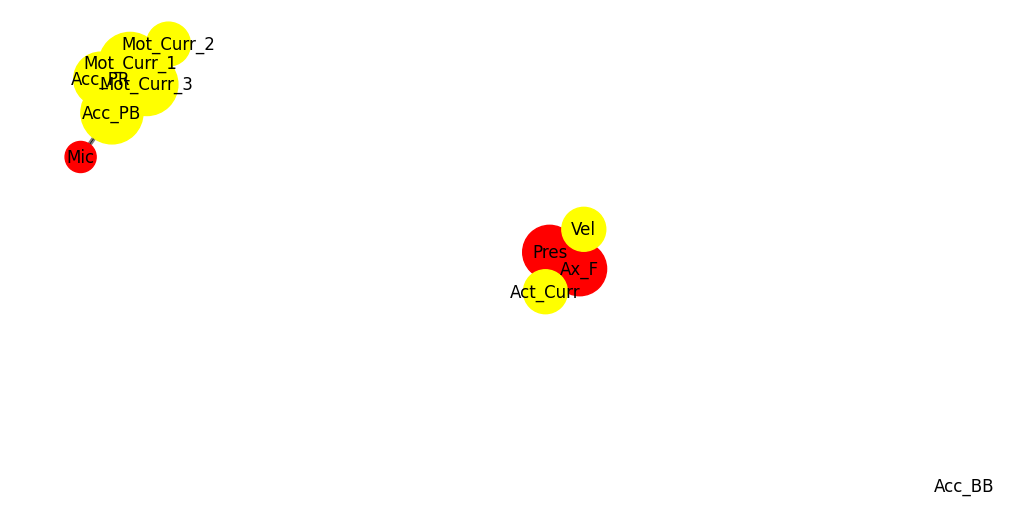

In [24]:
data_1 = random.choice([t for t in train_dataset])
mol = to_molecule(data_1)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [25]:
for u, v in mol.edges():
    print(10*np.abs(mol[u][v]['edge_attr'])**.5)

4.651483304850233
5.473415966905847
3.9141550762572983
3.9628637847544343
4.323313120912447
4.038036183896384
9.675293694839379
4.060533280000968
8.467022830182385
6.703888023868082
8.203207321891044
7.072372250719541
7.101824412120287
7.037390908132241


In [26]:
T=1/2000.0
N=2000
y = fft(train_data_reshaped[0][0])
xf = fftfreq(N, T)[:N//2]

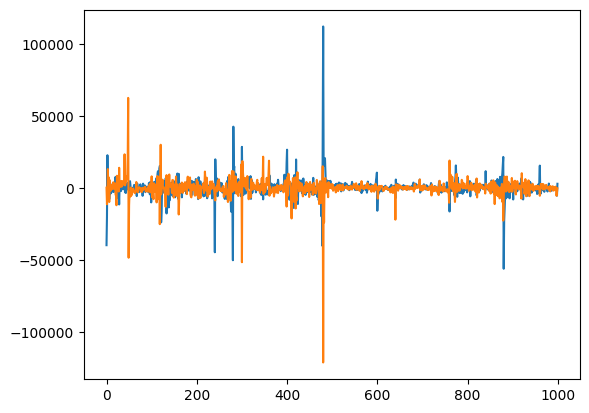

In [27]:
plt.plot(xf, 2.0/N * np.real(y[0:N//2]))
plt.plot(xf, 2.0/N * np.imag(y[0:N//2]))

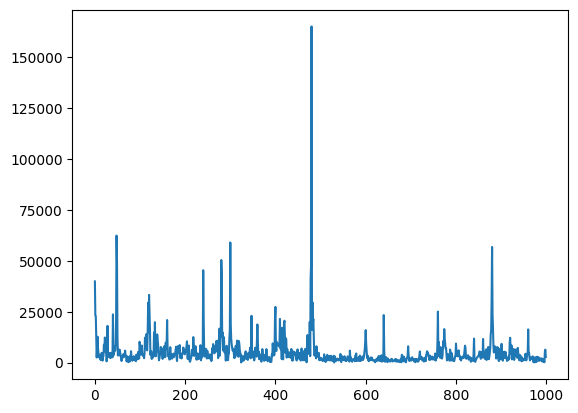

In [28]:
plt.plot(xf, 2.0/N * np.abs(y[0:N//2]))

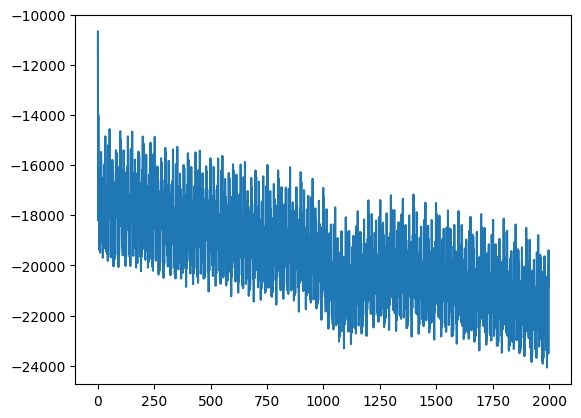

In [29]:
plt.plot(train_data_reshaped[500][7])

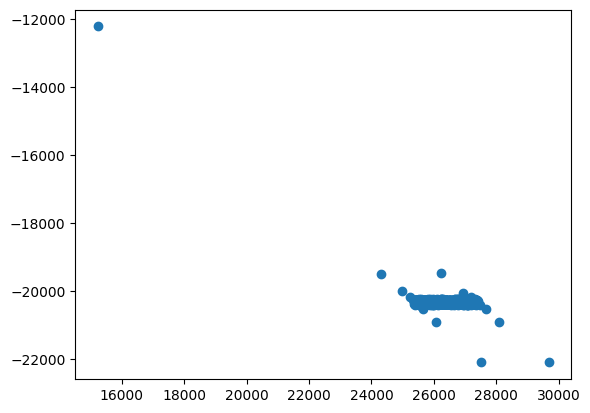

In [30]:
plt.scatter(train_data_reshaped[0][5], train_data_reshaped[0][6])

In [31]:
np.abs(y[0:N//2]).max() / np.abs(y[0:N//2]).min()

1995.7650435924772

In [32]:
alldat=[]
for k in range(11):
    T=1/2000.0
    N=2000
    y = fft(train_data_reshaped[0][k])
#     plt.scatter((k+1)*np.ones(1000), 2.0/N * np.abs(y[0:N//2]))
    alldat.append(np.abs(y))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa8a7a70c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa8a7a71150>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa8a7a70970>,
 'medians': [<matplotlib.lines.Line2D at 0x7fa8a7a71690>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa8a7a71930>,
 'means': []}

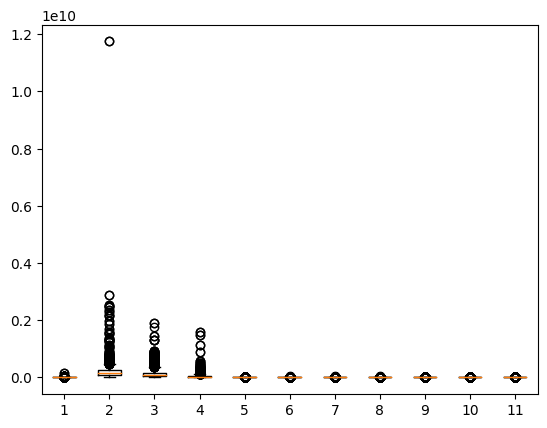

In [33]:
plt.boxplot(alldat)

In [34]:
df_temp=pd.DataFrame(train_data_reshaped[0].T, columns=sensor_names)

In [35]:
triu_ind = np.triu_indices(11, k = 1)
corr_mat = np.corrcoef(train_data_reshaped[0])
corr_arr=np.reshape(corr_mat[triu_ind], (55,-1))

In [36]:
np.append(corr_arr, np.linspace(1,55,55).reshape(55,-1), axis=1)

array([[-4.49189180e-01,  1.00000000e+00],
       [ 4.04890484e-03,  2.00000000e+00],
       [-2.31816764e-01,  3.00000000e+00],
       [ 2.49738081e-03,  4.00000000e+00],
       [-1.85342538e-03,  5.00000000e+00],
       [-2.44457663e-03,  6.00000000e+00],
       [ 3.31021144e-02,  7.00000000e+00],
       [ 2.41444599e-02,  8.00000000e+00],
       [ 1.19028147e-01,  9.00000000e+00],
       [-1.41164178e-01,  1.00000000e+01],
       [-3.99853143e-02,  1.10000000e+01],
       [ 4.12508906e-01,  1.20000000e+01],
       [-1.08209062e-02,  1.30000000e+01],
       [-6.97466635e-03,  1.40000000e+01],
       [ 5.88861915e-03,  1.50000000e+01],
       [-1.77191130e-02,  1.60000000e+01],
       [ 5.25199184e-02,  1.70000000e+01],
       [ 2.00364044e-02,  1.80000000e+01],
       [-7.61171482e-02,  1.90000000e+01],
       [-1.81233967e-02,  2.00000000e+01],
       [ 1.01876542e-01,  2.10000000e+01],
       [ 1.01892147e-01,  2.20000000e+01],
       [-2.82198624e-02,  2.30000000e+01],
       [-7.

In [37]:
torch.tensor(np.array(list(itertools.permutations(range(1,12), 2))).T)

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
         11, 11],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  3,  4,  5,  6,  7,  8,  9,
         10, 11,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  5,  6,  7,
          8,  9, 10, 11,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,
          5,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11,  1,  2,
          3,  4,  5,  6,  7,  9, 10, 11,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11,
          1,  2,  3,  4,  5,  6,  7,  8,  9, 11,  1,  2,  3,  4,  5,  6,  7,  8,
          

In [38]:
triu_ind

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
        5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  2,  3,  4,  5,  6,  7,  8,
         9, 10,  3,  4,  5,  6,  7,  8,  9, 10,  4,  5,  6,  7,  8,  9, 10,
         5,  6,  7,  8,  9, 10,  6,  7,  8,  9, 10,  7,  8,  9, 10,  8,  9,
        10,  9, 10, 10]))

In [39]:
corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.median(np.abs(edge_attr)))

edge_index_perm[:, corr_edge_inds[:,0]].shape

torch.Size([2, 9])

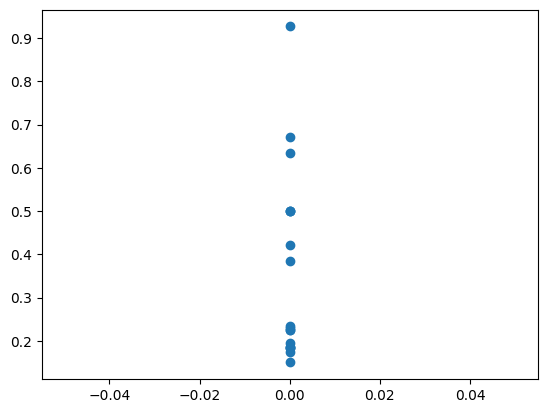

In [40]:
plt.scatter(np.zeros_like(edge_attr), np.abs(edge_attr))

In [41]:
combs = itertools.combinations(range(11), 2)
sample = train_data_reshaped[100]
offset = []
for k, l in combs:
    d1 = pd.Series(sample[k])
    d2 = pd.Series(sample[l])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(500),int(501), 25)]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

In [42]:
corr_mat = np.corrcoef(sample)
edge_attr = np.append(np.reshape(corr_mat[triu_ind], (55,-1)), np.array(offset).reshape(55,-1), axis=1)
#     edge_attr = np.reshape(corr_mat[triu_ind], (55,-1))
corr_edge_inds = np.argwhere(np.abs(edge_attr) > np.abs(edge_attr).mean())

In [43]:
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = torch.tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
sample = train_data_reshaped[100]
corr_mat = np.corrcoef(sample)
corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]

In [44]:
corr_vec[corr_edge_inds[:,0]]

array([[-0.19698969],
       [ 0.30725713],
       [ 0.14285867],
       [-0.14278971],
       [-0.17285555],
       [ 0.14125781],
       [ 0.9310461 ],
       [-0.17653643],
       [-0.69871563],
       [-0.47283063],
       [-0.65210512],
       [-0.50035519],
       [-0.50464019],
       [-0.49486186]])

In [45]:
offset = []
for node_inds in edge_inds.T:
    d1 = pd.Series(sample[node_inds[0]])
    d2 = pd.Series(sample[node_inds[1]])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(150),int(151), 50)]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

np.stack((corr_vec[corr_edge_inds[:,0]].flatten(), np.array(offset)), axis=-1)

array([[-0.19698969, -3.        ],
       [ 0.30725713,  0.        ],
       [ 0.14285867,  3.        ],
       [-0.14278971, -3.        ],
       [-0.17285555, -3.        ],
       [ 0.14125781,  2.        ],
       [ 0.9310461 ,  1.        ],
       [-0.17653643, -2.        ],
       [-0.69871563,  3.        ],
       [-0.47283063, -1.        ],
       [-0.65210512,  3.        ],
       [-0.50035519, -3.        ],
       [-0.50464019,  3.        ],
       [-0.49486186, -3.        ]])

In [46]:
dataset[4500].edge_attr

tensor([[-0.1765],
        [ 0.3780],
        [-0.3211],
        [ 0.3245],
        [-0.5004],
        [ 0.9333],
        [-0.1633],
        [-0.6944],
        [-0.4543],
        [-0.6459],
        [-0.4995],
        [-0.5045],
        [-0.4958]], dtype=torch.float64)

In [47]:
offset=[]
for node_inds in edge_inds.T:
    d1 = pd.Series(sample[node_inds[0]])
    d2 = pd.Series(sample[node_inds[1]])
    rs = [crosscorr(d1, d2, lag) for lag in range(-int(10),int(11))]
    offset.append(np.floor(len(rs)/2)-np.argmax(rs))

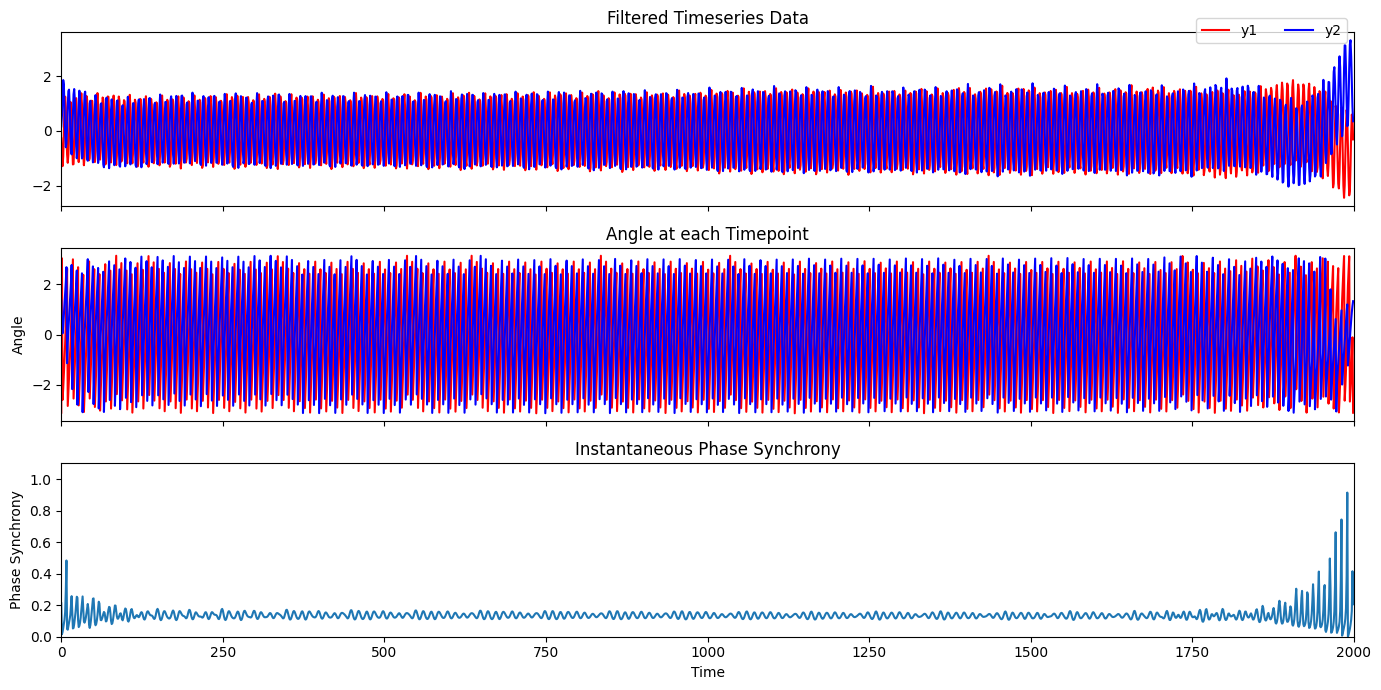

In [48]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = 10
highcut = 500
fs = 2000.
order = 4
d1 = pd.Series(array[8]).interpolate().values
d2 = pd.Series(array[9]).interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()

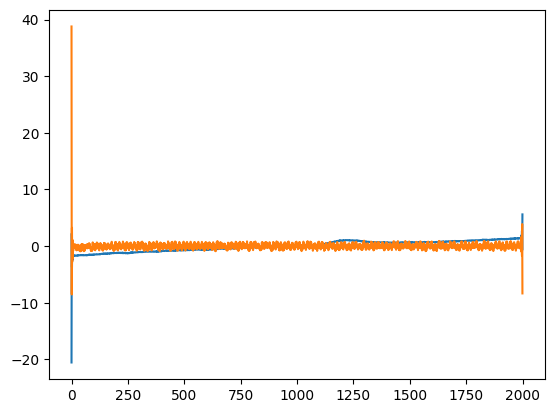

In [49]:
plt.plot(array[5])
plt.plot(array[6])

In [50]:
scaler = StandardScaler()
array = scaler.fit_transform(sample.T).T
array_fft = np.abs(fft(array))[:N//2]

In [51]:
xf = fftfreq(N, Tsig)[:N//2]

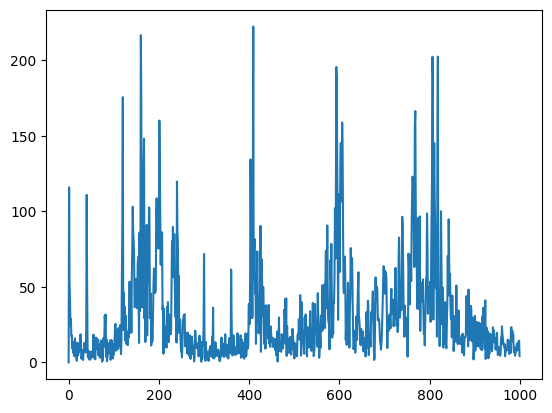

In [52]:
plt.plot(xf,array_fft[2][:N//2])

In [53]:
array_fft.shape

(11, 2000)

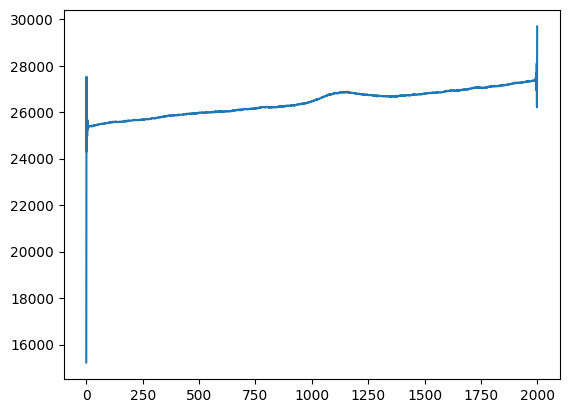

In [54]:
plt.plot(train_data_reshaped[0,5])

In [55]:
print(array_fft[10,1999])

1.471295556326855


In [62]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool
num_features = 2000
#num_features = array_fft.shape
num_classes = 11

class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()
        #num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        #self.lin2 = Linear(dim, dataset.num_classes)
        self.lin2 = Linear(dim, num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


In [63]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)

        # target = data.y.reshape(-1).long()
        # target = target.view(-1, 1).repeat(1, data.x.size(1)).view(-1)
        # loss = F.nll_loss(output, target)

        loss = F.nll_loss(output, data.y.long())
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        #print(pred)
        correct += pred.eq(data.y).sum().item()
        #print(correct)
        
    return correct / len(loader.dataset)

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
train_acc_values = []
test_acc_values = []
num_epochs = 100
patience = 3
best_val_loss = float('inf')
best_model = None
no_improvement = 0

#for epoch in range(1, 101):
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    loss_values.append(loss)
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Check if validation loss improved
    if len(loss_values) > 1 and loss_values[-1] >= loss_values[-2]:
        no_improvement += 1
    else:
        no_improvement = 0

    # Check if early stopping condition is met
    if no_improvement >= patience:
        print(f"Early stopping. No improvement for {no_improvement} epochs.")
        break


Epoch: 001, Loss: 2.9462, Train Acc: 0.2734, Test Acc: 0.3046
Epoch: 002, Loss: 2.0166, Train Acc: 0.4175, Test Acc: 0.4223
Epoch: 003, Loss: 1.7562, Train Acc: 0.4914, Test Acc: 0.5000
Epoch: 004, Loss: 1.5184, Train Acc: 0.6483, Test Acc: 0.6429
Epoch: 005, Loss: 1.2729, Train Acc: 0.7037, Test Acc: 0.6891
Epoch: 006, Loss: 1.1282, Train Acc: 0.7366, Test Acc: 0.6933
Epoch: 007, Loss: 0.9997, Train Acc: 0.7538, Test Acc: 0.7143
Epoch: 008, Loss: 0.9159, Train Acc: 0.7259, Test Acc: 0.6828
Epoch: 009, Loss: 0.8613, Train Acc: 0.7846, Test Acc: 0.7647
Epoch: 010, Loss: 0.8033, Train Acc: 0.7522, Test Acc: 0.7038
Epoch: 011, Loss: 0.7647, Train Acc: 0.8317, Test Acc: 0.8046
Epoch: 012, Loss: 0.7127, Train Acc: 0.8016, Test Acc: 0.7542
Epoch: 013, Loss: 0.6863, Train Acc: 0.8408, Test Acc: 0.8109
Epoch: 014, Loss: 0.6760, Train Acc: 0.8126, Test Acc: 0.7857
Epoch: 015, Loss: 0.6374, Train Acc: 0.8436, Test Acc: 0.8214
Epoch: 016, Loss: 0.6060, Train Acc: 0.8545, Test Acc: 0.8340
Epoch: 0

In [ ]:
plt.figure(figsize=(10, 6))

# Plot lines with different styles and colors
plt.plot(epochs, loss_values, color='blue', linestyle='-', marker='o', label='Loss')
plt.plot(epochs, train_acc_values, color='green', linestyle='--', marker='s', label='Train Accuracy')
plt.plot(epochs, test_acc_values, color='red', linestyle=':', marker='^', label='Test Accuracy')

# Set title and labels
plt.title('Training and Testing Results')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend and position it
plt.legend(loc='lower right')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust axis limits and ticks
plt.xlim(1, 20)
plt.xticks(range(0, 21, 4))
plt.ylim(0, 1)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [ ]:
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

data = random.choice([t for t in test_dataset])
mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)